# Online Selection of HLS Representations

In [1]:
from lrcb.bandits.multirep_finite import FiniteMultiBandit
from lrcb.representations.finite_representations import make_random_rep, hls_rank, rank, derank_hls
from lrcb.representations.finite_representations import is_cmb, is_hls, spans
from lrcb.algos.oful import oful
from lrcb.algos.lr_oful import select_oful
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lrcb.visualization.notebook_utils as nu

## Problem settings (common)

In [2]:
nc = 100
na = 5
dim = 20
noise = 0.1
seeds = [1, 2, 3, 4, 5]

## CMB, destructive approach, same parameter

Generate HLS representation

In [3]:
r0 = make_random_rep(nc, na, dim, normalize=True)
assert is_hls(r0)

Generate non-HLS equivalent representations with varying HLS rank

In [4]:
reps = [derank_hls(r0, i, transform=False) for i in range(1, dim)]
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert np.allclose(r._param, reps[-1]._param) #with the same parameter!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    print('%d/%d %s' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else ''))
print('%d/%d %s' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else ''))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20 (CMB)
2/20 (CMB)
3/20 (CMB)
4/20 (CMB)
5/20 (CMB)
6/20 (CMB)
7/20 (CMB)
8/20 (CMB)
9/20 (CMB)
10/20 (CMB)
11/20 (CMB)
12/20 (CMB)
13/20 (CMB)
14/20 (CMB)
15/20 (CMB)
16/20 (CMB)
17/20 (CMB)
18/20 (CMB)
19/20 (CMB)
20/20 (CMB)


OFUL settings

In [5]:
iterations = 1000
reg = 0.1
delta = 0.1
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

Regret of OFUL with different representations

In [6]:
names = []
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

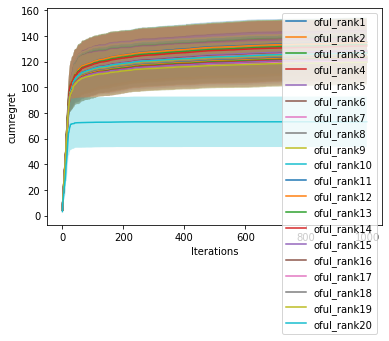

In [7]:
names = ['oful_rank%d' % (i+1) for i in range(dim)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [8]:
nu.tournament('../logs', names, 'cumregret', seeds)

[('oful_rank20', 73.19881856954446),
 ('oful_rank19', 119.59188938281264),
 ('oful_rank18', 119.67043331044458),
 ('oful_rank17', 120.6365368726243),
 ('oful_rank16', 120.89174472751544),
 ('oful_rank15', 121.93893153678),
 ('oful_rank14', 122.42987655996971),
 ('oful_rank13', 122.9905537191077),
 ('oful_rank12', 123.79311437608165),
 ('oful_rank11', 124.25453179887168),
 ('oful_rank9', 126.5510899093093),
 ('oful_rank10', 126.86909619500207),
 ('oful_rank8', 126.95030014140636),
 ('oful_rank7', 127.3548352944136),
 ('oful_rank6', 127.886506757204),
 ('oful_rank5', 128.7240079594012),
 ('oful_rank4', 132.31416704236858),
 ('oful_rank3', 133.30582847103634),
 ('oful_rank2', 134.97801249519551),
 ('oful_rank1', 135.34591781941012)]

Regret of model-selection algorithm compared to best model

In [9]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='oful_select')

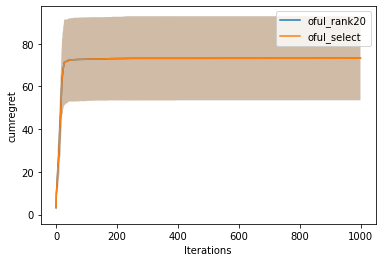

In [10]:
names = ['oful_rank%d' % dim, 'oful_select']
        
nu.compare('../logs', names, 'cumregret', seeds)

Representations selected by model-selection algorithm

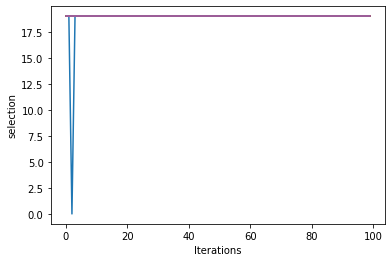

In [11]:
nu.plot_all('../logs', 'oful_select', 'selection', seeds, rows=100)

## CMB, destructive approach, different parameter

Re-use the same original HLS representation

Generate non-HLS **equivalent** representations with varying HLS rank **and different parameters**

In [12]:
reps = [derank_hls(r0, i, transform=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    print('%d/%d %s' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else ''))
print('%d/%d %s' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else ''))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20 (CMB)
2/20 (CMB)
3/20 (CMB)
4/20 (CMB)
5/20 (CMB)
6/20 (CMB)
7/20 (CMB)
8/20 (CMB)
9/20 (CMB)
10/20 (CMB)
11/20 (CMB)
12/20 (CMB)
13/20 (CMB)
14/20 (CMB)
15/20 (CMB)
16/20 (CMB)
17/20 (CMB)
18/20 (CMB)
19/20 (CMB)
20/20 (CMB)


OFUL settings

In [13]:
iterations = 1000
reg = 0.1
delta = 0.1
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

Regret of OFUL with different representations

In [14]:
names = []
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(t)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

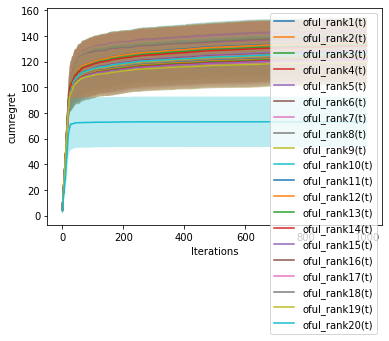

In [15]:
names = ['oful_rank%d(t)' % (i+1) for i in range(dim)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [16]:
nu.tournament('../logs', names, 'cumregret', seeds)

[('oful_rank20(t)', 73.19881856954446),
 ('oful_rank19(t)', 119.59188938281265),
 ('oful_rank18(t)', 119.67043331044461),
 ('oful_rank17(t)', 120.6365368726243),
 ('oful_rank16(t)', 120.89174472751556),
 ('oful_rank15(t)', 121.93893153677989),
 ('oful_rank14(t)', 122.42987655996971),
 ('oful_rank13(t)', 122.99055371910762),
 ('oful_rank12(t)', 123.79311437608166),
 ('oful_rank11(t)', 124.25453179887143),
 ('oful_rank9(t)', 126.5510899093094),
 ('oful_rank10(t)', 126.86909619500197),
 ('oful_rank8(t)', 126.95030014140613),
 ('oful_rank7(t)', 127.35483529441383),
 ('oful_rank6(t)', 127.88650675720392),
 ('oful_rank5(t)', 128.72400795940132),
 ('oful_rank4(t)', 132.31416704236864),
 ('oful_rank3(t)', 133.3058284710363),
 ('oful_rank2(t)', 134.97801249519563),
 ('oful_rank1(t)', 135.34591781941032)]

Regret of model-selection algorithm compared to best model

In [17]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='oful_select(t)')

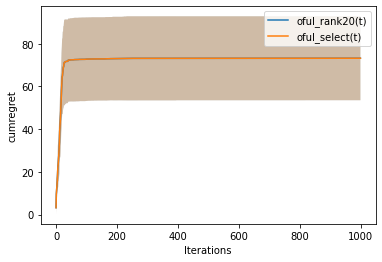

In [18]:
names = ['oful_rank%d(t)' % dim, 'oful_select(t)']
        
nu.compare('../logs', names, 'cumregret', seeds)

Representations selected by model-selection algorithm

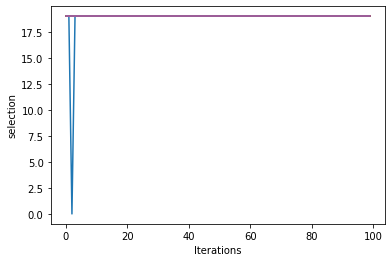

In [19]:
nu.plot_all('../logs', 'oful_select(t)', 'selection', seeds, rows=100)